In [1]:
# Only run this once to install bioconductor packages
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install("GEOquery")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.22 (BiocManager 1.30.27), R 4.5.2 (2025-10-31)

Installing package(s) 'BiocVersion', 'GEOquery'

also installing the dependencies ‘bit’, ‘prettyunits’, ‘XVector’, ‘bit64’, ‘progress’, ‘SparseArray’, ‘BiocGenerics’, ‘clipr’, ‘hms’, ‘vroom’, ‘tzdb’, ‘statmod’, ‘XML’, ‘R.oo’, ‘R.methodsS3’, ‘MatrixGenerics’, ‘GenomicRanges’, ‘IRanges’, ‘Seqinfo’, ‘S4Arrays’, ‘DelayedArray’, ‘selectr’, ‘Biobase’, ‘readr’, ‘xml2’, ‘limma’, ‘rentrez’, ‘R.utils’, ‘SummarizedExperiment’, ‘S4Vectors’, ‘rvest’, ‘httr2’


Warning message in install.packages(...):
“installation of package ‘bit’ had non-zero exit status”
Warning message in install.packages(...):
“installation of package ‘tzdb’ had non-zero exit status”
Wa

In [3]:
# Install required packages (only run once)
install.packages("Matrix")
install.packages("dplyr")

Warning message in install.packages("Matrix"):
“installation of package ‘Matrix’ had non-zero exit status”
Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Warning message in install.packages("dplyr"):
“installation of package ‘dplyr’ had non-zero exit status”
Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
library(Seurat)
library(Matrix)
library(dplyr)
library(ggplot2)
library(pheatmap)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [5]:
print("Downloading Primary Sjögren's Syndrome dataset from GEO (GSE157278)...")

# Create temp directory
dir.create("./gse157278_data", showWarnings = FALSE)

# Download files
print("Downloading expression matrix...")
download.file(
  "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE157278&format=file&file=GSE157278_matrix.mtx.gz",
  "./gse157278_data/matrix.mtx.gz",
  quiet = TRUE
)

print("Downloading features (genes)...")
download.file(
  "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE157278&format=file&file=GSE157278_features.tsv.gz",
  "./gse157278_data/features.tsv.gz",
  quiet = TRUE
)

print("Downloading barcodes (cells)...")
download.file(
  "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE157278&format=file&file=GSE157278_barcodes.tsv.gz",
  "./gse157278_data/barcodes.tsv.gz",
  quiet = TRUE
)

print("Downloading cell batch info...")
download.file(
  "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE157278&format=file&file=GSE157278_cell_batch.tsv.gz",
  "./gse157278_data/cell_batch.tsv.gz",
  quiet = TRUE
)

print("Extracting files...")
system("cd ./gse157278_data && gunzip -f *.gz")

print("Download complete!")

[1] "Downloading Primary Sjögren's Syndrome dataset from GEO (GSE157278)..."
[1] "Downloading expression matrix..."
[1] "Downloading features (genes)..."
[1] "Downloading barcodes (cells)..."
[1] "Downloading cell batch info..."
[1] "Extracting files..."
[1] "Download complete!"


In [7]:
print("Loading expression matrix...")
expr_matrix <- readMM("./gse157278_data/matrix.mtx")

# Load features (genes)
features <- read.table("./gse157278_data/features.tsv", stringsAsFactors = FALSE)

# Check for duplicates
print(paste("Total genes:", nrow(features)))
print(paste("Unique genes:", length(unique(features[, 2]))))


[1] "Loading expression matrix..."
[1] "Total genes: 33694"
[1] "Unique genes: 33660"


In [8]:
# Make gene names unique by adding a suffix if there are duplicates
gene_names <- make.names(features[, 2], unique = TRUE)
rownames(expr_matrix) <- gene_names

# Load barcodes (cell IDs)
barcodes <- read.table("./gse157278_data/barcodes.tsv", stringsAsFactors = FALSE)
colnames(expr_matrix) <- barcodes[, 1]

# Load cell batch/disease info
cell_batch <- read.table("./gse157278_data/cell_batch.tsv", header = TRUE, stringsAsFactors = FALSE)
rownames(cell_batch) <- cell_batch$barcode

print(paste("Expression matrix loaded:", nrow(expr_matrix), "genes x", ncol(expr_matrix), "cells"))
print("Cell batch info:")
print(table(cell_batch$disease))

[1] "Expression matrix loaded: 33694 genes x 61405 cells"
[1] "Cell batch info:"
< table of extent 0 >


In [9]:
# Create Seurat object
print("Creating Seurat object...")
seurat_obj <- CreateSeuratObject(
  counts = expr_matrix,
  meta.data = cell_batch[colnames(expr_matrix), ],
  min.cells = 3,
  min.features = 200
)

print(paste("Seurat object created with", ncol(seurat_obj), "cells and", nrow(seurat_obj), "genes"))

# Save object
saveRDS(seurat_obj, "seurat_raw.rds")
print("Saved: seurat_raw.rds")

[1] "Creating Seurat object..."


Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Data is of class dgTMatrix. Coercing to dgCMatrix.”
Warning message:
“Cannot add more or less meta data without cell names”


[1] "Seurat object created with 60671 cells and 21176 genes"
[1] "Saved: seurat_raw.rds"


In [1]:
print("Loading raw Seurat object...")
seurat_obj <- readRDS("seurat_raw.rds")

print(paste("Starting QC. Cells:", ncol(seurat_obj)))

[1] "Loading raw Seurat object..."


Loading required namespace: SeuratObject



[1] "Starting QC. Cells: 60671"


In [3]:
# Calculate mitochondrial percentage
seurat_obj[["percent.mt"]] <- PercentageFeatureSet(seurat_obj, pattern = "^MT-")

In [4]:
# QC filtering
seurat_obj <- subset(seurat_obj,
  subset = nFeature_RNA > 200 &
    nFeature_RNA < 2500 &
    percent.mt < 20
)

print(paste("After QC filtering. Cells retained:", ncol(seurat_obj)))

[1] "After QC filtering. Cells retained: 58423"


In [5]:
# Normalization
print("Normalizing...")
seurat_obj <- NormalizeData(seurat_obj, normalization.method = "LogNormalize", scale.factor = 10000)

[1] "Normalizing..."


Normalizing layer: counts



In [6]:
# Find highly variable genes
print("Finding highly variable genes...")
seurat_obj <- FindVariableFeatures(seurat_obj, selection.method = "vst", nfeatures = 2000)

[1] "Finding highly variable genes..."


Finding variable features for layer counts



In [7]:
# Scale data (skip for now, do it later if needed)
print("Skipping full scaling to save memory...")

print(paste("HVGs identified:", length(VariableFeatures(seurat_obj))))

[1] "Skipping full scaling to save memory..."
[1] "HVGs identified: 2000"


In [8]:
# Save
saveRDS(seurat_obj, "seurat_preprocessed.rds")
print("Saved: seurat_preprocessed.rds")

[1] "Saved: seurat_preprocessed.rds"


In [9]:
print("Loading preprocessed object...")
seurat_obj <- readRDS("seurat_preprocessed.rds")

print(paste("Starting dimensionality reduction. Cells:", ncol(seurat_obj)))

[1] "Loading preprocessed object..."
[1] "Starting dimensionality reduction. Cells: 58423"


In [10]:
# Scale data (only for HVGs to save memory)
print("Scaling HVGs...")
seurat_obj <- ScaleData(seurat_obj, features = VariableFeatures(seurat_obj))

[1] "Scaling HVGs..."


Centering and scaling data matrix



In [11]:
# PCA
print("Running PCA...")
seurat_obj <- RunPCA(seurat_obj, features = VariableFeatures(seurat_obj), npcs = 30)

[1] "Running PCA..."


PC_ 1 
Positive:  IFITM1, IL32, ZFP36L2, IL7R, LDHB, RPS6, CD7, RPS18, LTB, CD69 
	   RPS3A, CD247, TCF7, LEF1, CAMK4, NOSIP, GZMM, CXCR4, ITM2A, ABLIM1 
	   OXNAD1, MAL, CCR7, CTSW, TRBC1, CD27, PCED1B, TPT1, HIST1H4C, CST7 
Negative:  FCN1, CST3, SERPINA1, LYZ, SPI1, CSTA, S100A8, LST1, S100A9, CFD 
	   CD68, VCAN, CD14, S100A12, PLAUR, CTSS, MS4A6A, AIF1, CLEC7A, NCF2 
	   MNDA, TYMP, IFI30, LGALS2, C5AR1, FPR1, CYBB, LILRB2, CFP, SLC11A1 
PC_ 2 
Positive:  LTB, GP9, TUBB1, C6orf25, GNG11, CMTM5, SPARC, SDPR, CCR7, TMEM40 
	   RGS10, CD79A, NGFRAP1, PTGS1, PF4, HIST1H2AC, ACRBP, TSC22D1, ESAM, C2orf88 
	   RGS18, TREML1, CLU, MS4A1, F13A1, PPBP, ACTN1, LEF1, AP003068.23, ITGA2B 
Negative:  NKG7, CST7, PRF1, GZMB, GZMA, CTSW, GNLY, FGFBP2, KLRD1, GZMH 
	   SPON2, FCGR3A, HOPX, CCL4, IFITM2, EFHD2, KLRF1, ITGB2, GZMM, CLIC3 
	   CD247, S1PR5, S100A4, PRSS23, PFN1, MATK, CYBA, CCL5, TYROBP, APMAP 
PC_ 3 
Positive:  RPS3A, RPS18, RPS6, LTB, TPT1, JUNB, CD37, CD55, SELL, CD79A 
	   CXCR4

In [12]:
# UMAP
print("Running UMAP...")
seurat_obj <- RunUMAP(seurat_obj, dims = 1:30)

[1] "Running UMAP..."


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
16:00:21 UMAP embedding parameters a = 0.9922 b = 1.112

16:00:21 Read 58423 rows and found 30 numeric columns

16:00:21 Using Annoy for neighbor search, n_neighbors = 30

16:00:21 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:00:24 Writing NN index file to temp file /tmp/RtmpDHDRHH/file2f01b8c8155

16:00:24 Searching Annoy index using 1 thread, search_k = 3000

16:00:47 Annoy recall = 100%

16:00:47 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors =

In [13]:
# Clustering
print("Clustering...")
seurat_obj <- FindNeighbors(seurat_obj, dims = 1:30)
seurat_obj <- FindClusters(seurat_obj, resolution = 0.5)

[1] "Clustering..."


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 58423
Number of edges: 2144394

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9428
Number of communities: 27
Elapsed time: 23 seconds


In [14]:
n_clusters <- length(unique(seurat_obj$seurat_clusters))
print(paste("Clusters identified:", n_clusters))

[1] "Clusters identified: 27"


In [15]:
# Plot UMAP by cluster
png("umap_clusters.png", width = 900, height = 800)
print(DimPlot(seurat_obj, reduction = "umap", label = TRUE, pt.size = 0.5))
dev.off()
print("Saved: umap_clusters.png")

pdf 
  2

[1] "Saved: umap_clusters.png"


In [17]:
# Save object
saveRDS(seurat_obj, "seurat_clustered.rds")
print("Saved: seurat_clustered.rds")

[1] "Saved: seurat_clustered.rds"


In [18]:
print("Loading clustered object...")
seurat_obj <- readRDS("seurat_clustered.rds")

[1] "Loading clustered object..."


In [19]:
# Check metadata columns
print("Available metadata columns:")
print(colnames(seurat_obj@meta.data))

[1] "Available metadata columns:"
[1] "orig.ident"      "nCount_RNA"      "nFeature_RNA"    "percent.mt"     
[5] "RNA_snn_res.0.5" "seurat_clusters"


In [20]:
# Check unique values in each column
print("\nMetadata summary:")
print(head(seurat_obj@meta.data))

[1] "\nMetadata summary:"
                      orig.ident nCount_RNA nFeature_RNA percent.mt
AAACCTGAGACCTAGG-1 SeuratProject       7134         1631          0
AAACCTGAGCCACCTG-1 SeuratProject       4895         1576          0
AAACCTGAGTCATCCA-1 SeuratProject       6924         2040          0
AAACCTGCAGATGAGC-1 SeuratProject       4969         1490          0
AAACCTGCATCCGCGA-1 SeuratProject        902          397          0
AAACCTGGTCGTTGTA-1 SeuratProject       5162         1193          0
                   RNA_snn_res.0.5 seurat_clusters
AAACCTGAGACCTAGG-1               7               7
AAACCTGAGCCACCTG-1               8               8
AAACCTGAGTCATCCA-1               6               6
AAACCTGCAGATGAGC-1               8               8
AAACCTGCATCCGCGA-1               6               6
AAACCTGGTCGTTGTA-1               7               7


In [21]:
# Look for disease/batch column
disease_cols <- colnames(seurat_obj@meta.data)[grep("disease|batch|group|status", 
                                                      tolower(colnames(seurat_obj@meta.data)))]
print(paste("\nColumns matching 'disease/batch/group':", paste(disease_cols, collapse = ", ")))

[1] "\nColumns matching 'disease/batch/group': "


In [25]:
print("Cell batch columns:")
print(colnames(seurat_obj@meta.data))

# Load cell batch info
cell_batch <- read.table("./gse157278_data/cell_batch.tsv", header = TRUE, stringsAsFactors = FALSE)
rownames(cell_batch) <- cell_batch$Cell

# Match and add batch info to object
cells_in_obj <- colnames(seurat_obj)
batch_matched <- cell_batch[cells_in_obj, "batch"]
seurat_obj$batch <- batch_matched

print("Batch distribution:")
print(table(seurat_obj$batch))

[1] "Cell batch columns:"
[1] "orig.ident"      "nCount_RNA"      "nFeature_RNA"    "percent.mt"     
[5] "RNA_snn_res.0.5" "seurat_clusters"
[1] "Batch distribution:"

 HC-1  HC-2  HC-3  HC-4  HC-5 pSS-1 pSS-2 pSS-3 pSS-4 pSS-5 
 4878  6211  6304  7270  3456  9157  4760  4449  4520  7418 


In [26]:
# Create disease status (HC vs pSS)
seurat_obj$disease_status <- ifelse(grepl("^HC", seurat_obj$batch), "Healthy Control", "pSS Patient")

print("Disease status distribution:")
print(table(seurat_obj$disease_status))

[1] "Disease status distribution:"

Healthy Control     pSS Patient 
          28119           30304 


In [27]:
# Plot by disease status
png("umap_disease_status.png", width = 900, height = 800)
print(DimPlot(seurat_obj, reduction = "umap", group.by = "disease_status", pt.size = 0.5))
dev.off()
print("Saved: umap_disease_status.png")

# Also plot by batch (individual samples)
png("umap_batch.png", width = 1000, height = 800)
print(DimPlot(seurat_obj, reduction = "umap", group.by = "batch", pt.size = 0.5))
dev.off()
print("Saved: umap_batch.png")

pdf 
  2

[1] "Saved: umap_disease_status.png"


pdf 
  2

[1] "Saved: umap_batch.png"


In [29]:
print(paste("Cells:", ncol(seurat_obj), "| Clusters:", length(unique(seurat_obj$seurat_clusters))))

[1] "Cells: 58423 | Clusters: 27"


In [2]:
print("Loading clustered object...")
seurat_obj <- readRDS("seurat_clustered.rds")

[1] "Loading clustered object..."


In [3]:
print("Finding pSS-specific biomarkers...")
print("Comparing: pSS Patients vs Healthy Controls")

disease_markers <- FindMarkers(
  seurat_obj,
  ident.1 = "pSS Patient",
  ident.2 = "Healthy Control",
  group.by = "disease_status",
  logfc.threshold = 0.25,
  min.pct = 0.25
)

[1] "Finding pSS-specific biomarkers..."
[1] "Comparing: pSS Patients vs Healthy Controls"


For a (much!) faster implementation of the Wilcoxon Rank Sum Test,
(default method for FindMarkers) please install the presto package
--------------------------------------------
install.packages('devtools')
devtools::install_github('immunogenomics/presto')
--------------------------------------------
After installation of presto, Seurat will automatically use the more 
efficient implementation (no further action necessary).
This message will be shown once per session



In [4]:
disease_markers$gene <- rownames(disease_markers)
disease_markers <- disease_markers[order(disease_markers$avg_log2FC, decreasing = TRUE), ]

In [5]:
print("Top 30 pSS-associated genes:")
print(head(disease_markers[, c("gene", "avg_log2FC", "p_val_adj")], 30))

[1] "Top 30 pSS-associated genes:"
               gene avg_log2FC     p_val_adj
HLA.DRB5   HLA.DRB5   2.042652  0.000000e+00
PPP1CA       PPP1CA   1.623416  0.000000e+00
GIMAP4       GIMAP4   1.374056  0.000000e+00
RPS26         RPS26   1.348196  0.000000e+00
TXNL4A       TXNL4A   1.312123  0.000000e+00
HDAC1         HDAC1   1.304888  0.000000e+00
PSMB8.AS1 PSMB8.AS1   1.304129  0.000000e+00
YPEL3         YPEL3   1.273163  0.000000e+00
TMEM179B   TMEM179B   1.193131  0.000000e+00
GZMA           GZMA   1.191603  0.000000e+00
PSMB2         PSMB2   1.174978  0.000000e+00
EFHD2         EFHD2   1.159236  0.000000e+00
SPN             SPN   1.158842  0.000000e+00
PRELID1     PRELID1   1.158531  0.000000e+00
APOBEC3G   APOBEC3G   1.158078 4.446314e-310
MRPL51       MRPL51   1.147302  0.000000e+00
GZMB           GZMB   1.138670 4.254857e-268
NCBP2.AS2 NCBP2.AS2   1.128551  0.000000e+00
TAF10         TAF10   1.123066  0.000000e+00
PDCD6         PDCD6   1.120176  0.000000e+00
PSMB10       PSMB10 

In [6]:
write.csv(disease_markers, "pss_vs_healthy_biomarkers.csv", row.names = FALSE)
print("Saved: pss_vs_healthy_biomarkers.csv")

print("✓ Biomarker discovery complete!")

[1] "Saved: pss_vs_healthy_biomarkers.csv"
[1] "✓ Biomarker discovery complete!"


In [10]:
# Load data
seurat_obj <- readRDS("seurat_clustered.rds")
disease_markers <- read.csv("pss_vs_healthy_biomarkers.csv")

In [11]:
# Get top 20 biomarkers
top_20_genes <- disease_markers %>%
  arrange(desc(avg_log2FC)) %>%
  head(20) %>%
  pull(gene)

In [12]:
# Extract expression data for heatmap
expr_data <- GetAssayData(seurat_obj, layer = "data")[top_20_genes, ]

# Average expression by cluster
cluster_means <- matrix(0, nrow = length(top_20_genes), ncol = length(unique(seurat_obj$seurat_clusters)))
rownames(cluster_means) <- top_20_genes
colnames(cluster_means) <- sort(unique(seurat_obj$seurat_clusters))

In [13]:
for (i in 1:ncol(cluster_means)) {
  cluster_id <- as.numeric(colnames(cluster_means)[i])
  cells_in_cluster <- WhichCells(seurat_obj, idents = cluster_id)
  cluster_means[, i] <- rowMeans(expr_data[, cells_in_cluster])
}

png 
  3

[1] "Saved: heatmap_top20_biomarkers_by_cluster.png"


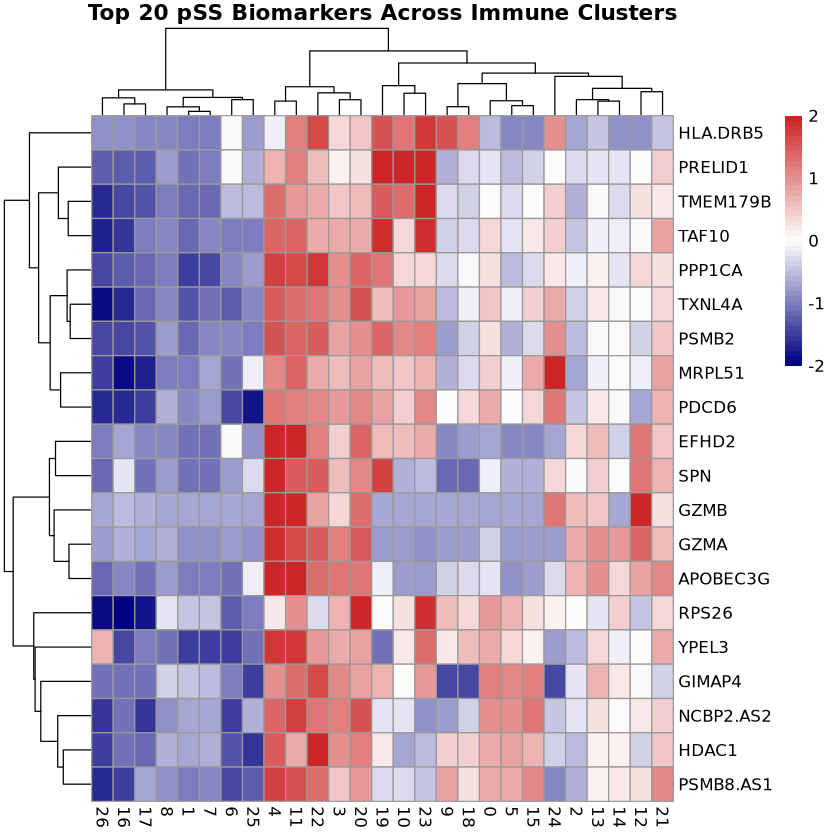

In [16]:
# Create heatmap
png("heatmap_top20_biomarkers_by_cluster.png", width = 1000, height = 600)
pheatmap(cluster_means,
         scale = "row",
         color = colorRampPalette(c("navy", "white", "firebrick3"))(50),
         main = "Top 20 pSS Biomarkers Across Immune Clusters",
         fontsize_row = 10,
         fontsize_col = 10,
         breaks = seq(-2, 2, length.out = 51))
dev.off()

print("Saved: heatmap_top20_biomarkers_by_cluster.png")

In [15]:
# Average by disease status
pss_cells <- WhichCells(seurat_obj, expression = disease_status == "pSS Patient")
healthy_cells <- WhichCells(seurat_obj, expression = disease_status == "Healthy Control")

disease_means <- data.frame(
  pSS = rowMeans(expr_data[, pss_cells]),
  Healthy = rowMeans(expr_data[, healthy_cells])
)

png 
  3

[1] "Saved: heatmap_biomarkers_disease_status.png"


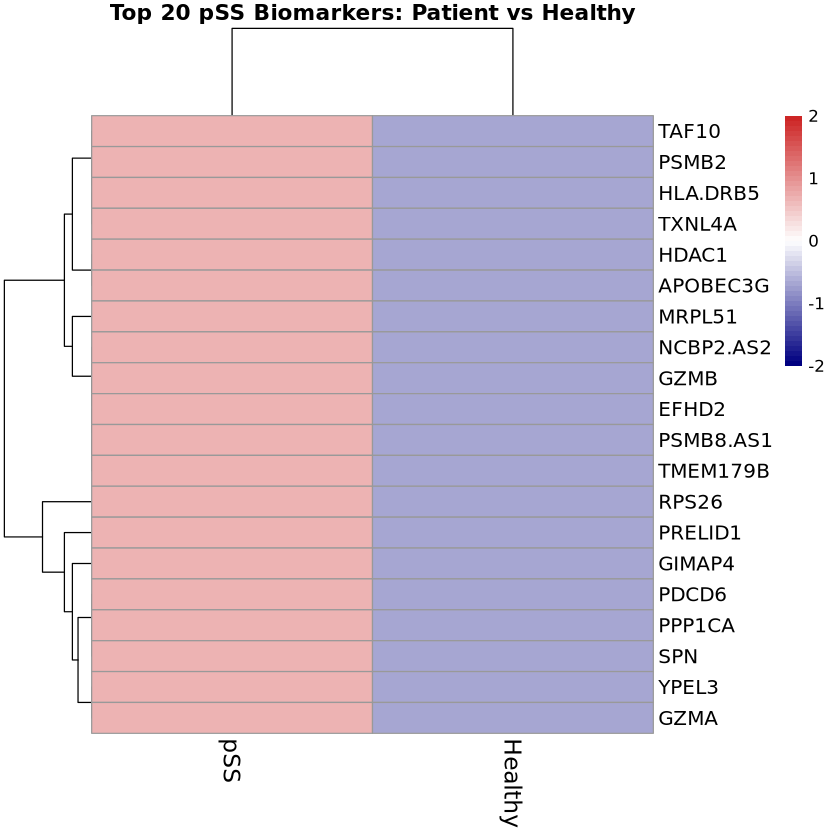

In [16]:
# Create heatmap
png("heatmap_biomarkers_disease_status.png", width = 600, height = 800)
pheatmap(disease_means,
         scale = "row",
         color = colorRampPalette(c("navy", "white", "firebrick3"))(50),
         main = "Top 20 pSS Biomarkers: Patient vs Healthy",
         fontsize_row = 12,
         fontsize_col = 14,
         breaks = seq(-2, 2, length.out = 51))
dev.off()

print("Saved: heatmap_biomarkers_disease_status.png")

In [4]:
seurat_obj <- readRDS("seurat_clustered.rds")

# Create violin plots for GZMA and GZMB
plot1 <- VlnPlot(seurat_obj, features = "GZMA", group.by = "disease_status", 
                  pt.size = 0, fill.by = "ident") +
  ggtitle("GZMA Expression: pSS vs Healthy") +
  theme(axis.title.x = element_blank())

plot2 <- VlnPlot(seurat_obj, features = "GZMB", group.by = "disease_status",
                  pt.size = 0, fill.by = "ident") +
  ggtitle("GZMB Expression: pSS vs Healthy") +
  theme(axis.title.x = element_blank())

# Combine plots
combined_plot <- plot1 / plot2

png("violin_GZMA_GZMB_by_disease.png", width = 800, height = 700)
print(combined_plot)
dev.off()

print("Saved: violin_GZMA_GZMB_by_disease.png")

agg_record_1857615451 
                    2

[1] "Saved: violin_GZMA_GZMB_by_disease.png"


In [6]:
# Feature plot for GZMA with matching aesthetics
plot1 <- FeaturePlot(seurat_obj, features = "GZMA", reduction = "umap", 
                     pt.size = 0.8, cols = c("lightgrey", "red")) +
  ggtitle("GZMA Expression") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5, size = 14))

# Feature plot for GZMB
plot2 <- FeaturePlot(seurat_obj, features = "GZMB", reduction = "umap",
                     pt.size = 0.8, cols = c("lightgrey", "red")) +
  ggtitle("GZMB Expression") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5, size = 14))

# Combine side by side
combined <- plot1 + plot2

png("featureplot_GZMA_GZMB_umap.png", width = 1400, height = 600)
print(combined)
dev.off()

print("Saved: featureplot_GZMA_GZMB_umap.png")

agg_record_418864070 
                   2

[1] "Saved: featureplot_GZMA_GZMB_umap.png"
